# Human PBMCs - merging annotated samples from Sun et al.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import glob

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

results_file = './write/Sun_hum_PBMCs_pp.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

## Load 
Here we load the pre-processed datasets (which has been annotated), and the raw matrices (which won't be filtered on the gene level). 

### Raw data

In [8]:
# Set up data loading
file_base = '../Munich/datasets/human/Sun_PBMC/'
folders = ['sample1_CS', 'sample2_KC', 'sample3_TB', 'sample4_TC']
geo_id = ['/GSM3665016_CS_PBL_', '/GSM3665017_KC_PBL_', '/GSM3665018_TB_PBL_', '/GSM3665019_TC_PBL_']
mat = 'matrix.mtx.gz'
barcode = 'barcodes.tsv.gz'
gene = 'genes.tsv.gz'

In [9]:
adatas_raw = []
# Loop to load data
for i in range(len(folders)):
    #Parse filenames
    folder = folders[i]
    geo = geo_id[i]
    data_file = file_base+folder+geo+mat
    barcode_file = file_base+folder+geo+barcode
    gene_file = file_base+folder+geo+gene
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()
    
    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['batch'] = ['Sun_'+folder]*adata_tmp.n_obs
    adata_tmp.obs['study'] = ['Sun']*adata_tmp.n_obs
    adata_tmp.obs['chemistry'] = ['10X']*adata_tmp.n_obs
    adata_tmp.obs['tissue'] = ['PBMCs']*adata_tmp.n_obs
    adata_tmp.obs['species'] = ['Human']*adata_tmp.n_obs
    adata_tmp.obs['data_type'] = ['UMI']*adata_tmp.n_obs

    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()
    
    #Append to main adata object
    adatas_raw.append(adata_tmp)


... reading from cache file cache/..-Munich-datasets-human-Sun_PBMC-sample1_CS-GSM3665016_CS_PBL_matrix.h5ad
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


In [17]:
# Concatenate to unique adata object
adata_raw = adatas_raw[0].concatenate(adatas_raw[1:], batch_key='sample_ID', 
                                               batch_categories=['Sun_'+folders[i] for i in range(len(folders))])

In [18]:
adata_raw.obs.head()

,batch,chemistry,data_type,sample_ID,species,study,tissue
AAACCTGCACAGACAG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Sun_sample1_CS,Human,Sun,PBMCs
AAACGGGCAGTAGAGC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Sun_sample1_CS,Human,Sun,PBMCs
AAACGGGCATGGTAGG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Sun_sample1_CS,Human,Sun,PBMCs
AAACGGGGTTCCGTCT-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Sun_sample1_CS,Human,Sun,PBMCs
AAACGGGTCATCGCTC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Sun_sample1_CS,Human,Sun,PBMCs


In [19]:
adata_raw.obs.drop(columns=['sample_ID'], inplace=True)
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue
AAACCTGCACAGACAG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGCAGTAGAGC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGCATGGTAGG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGGTTCCGTCT-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGTCATCGCTC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs


In [20]:
adata_raw.obs.index.rename('barcode', inplace=True)
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue
barcode,,,,,,
AAACCTGCACAGACAG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGCAGTAGAGC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGCATGGTAGG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGGTTCCGTCT-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs
AAACGGGTCATCGCTC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs


In [21]:
adata_raw.shape

(8922, 32738)

### Pre-processed data

In [3]:
file_paths = '../PBMC_human/write/Sun'
adatas_pp = []
for i in glob.glob(file_paths+'*.h5ad'):
    print(i)
    adatas_pp.append(sc.read(i, cache=True)) 

../PBMC_human/write/Sun1_pbmcs.h5ad
../PBMC_human/write/Sun4_pbmcs.h5ad
../PBMC_human/write/Sun3_pbmcs.h5ad
../PBMC_human/write/Sun2_pbmcs.h5ad


In [39]:
folders = ['sample1_CS', 'sample4_TC', 'sample3_TB', 'sample2_KC']
for i in range(len(adatas_pp)):
    adata_tmp = adatas_pp[i]
    adata_obs = adata_tmp.obs.reset_index()
    adata_obs = adata_obs[['index', 'final_annotation', 'n_counts', 'n_genes', 'mt_frac']].rename(columns = {'index':'barcode'})
    adata_obs['barcode'] = adata_obs['barcode']+['-Sun_'+folders[i]]*adata_tmp.n_obs
    adata_obs.set_index('barcode', inplace = True)
    adatas_pp[i].obs = adata_obs
    

In [40]:
# Concatenate to unique adata object
adata_pp = adatas_pp[0].concatenate(adatas_pp[1:], batch_key='sample_ID',
                                                        index_unique=None)

In [41]:
adata_pp.obs.drop(columns=['sample_ID'], inplace = True)

In [42]:
adata_raw.shape

(8922, 32738)

In [43]:
adata_pp.shape

(8829, 9699)

In [44]:
# Restrict to cells that passed QC and were annotated
adata_obs_raw = adata_raw.obs.reset_index()
adata_obs_pp = adata_pp.obs.reset_index()
adata_merged = adata_obs_raw.merge(adata_obs_pp, on='barcode', how='left')
adata_merged.set_index('barcode', inplace = True)
adata_raw.obs = adata_merged
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue,final_annotation,mt_frac,n_counts,n_genes
barcode,,,,,,,,,,
AAACCTGCACAGACAG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs,CD4+ T cells,0.023411,5083.0,1269.0
AAACGGGCAGTAGAGC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs,CD4+ T cells,0.033540,4025.0,1314.0
AAACGGGCATGGTAGG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs,CD4+ T cells,0.020093,5574.0,1246.0
AAACGGGGTTCCGTCT-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs,CD4+ T cells,0.021680,6227.0,1381.0
AAACGGGTCATCGCTC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,Human,Sun,PBMCs,CD4+ T cells,0.068300,8287.0,1892.0


In [45]:
adata_raw = adata_raw[~pd.isnull(adata_raw.obs['final_annotation'])]
adata_raw.shape

(8829, 32738)

### Normalization

In [46]:
# Exclude genes that are = 0 in all cells
#Filter genes:
print('Total number of genes: {:d}'.format(adata_raw.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_raw, min_cells=1)
print('Number of genes after cell filter: {:d}'.format(adata_raw.n_vars))

Total number of genes: 32738
filtered out 12348 genes that are detectedin less than 1 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 20390


In [47]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata_raw.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [48]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     1629
1     1614
2      783
3      773
4      764
5      761
6      688
7      657
8      444
9      409
10     239
11      68
Name: groups, dtype: int64

In [49]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_raw.X.T

In [50]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [51]:
#Delete adata_pp
del adata_pp

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'final_annotation' as categorical


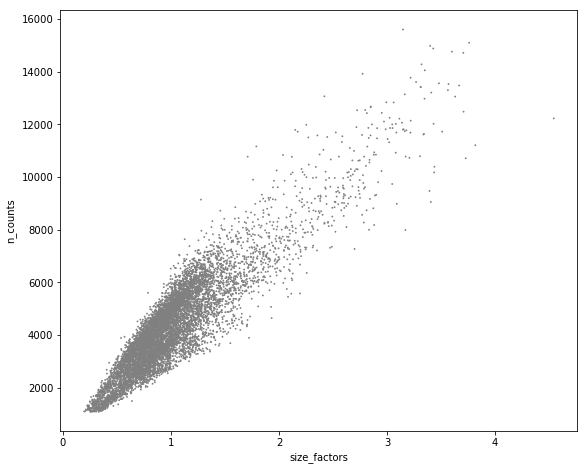

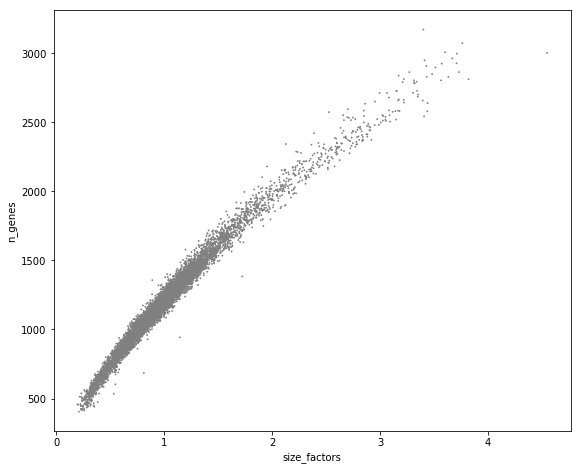

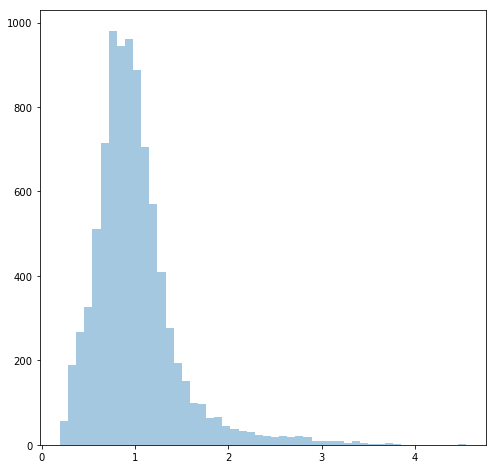

In [52]:
# Visualize the estimated size factors
adata_raw.obs['size_factors'] = size_factors

sc.pl.scatter(adata_raw, 'size_factors', 'n_counts')
sc.pl.scatter(adata_raw, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [53]:
#Keep the count data in a counts layer
adata_raw.layers["counts"] = adata_raw.X.copy()

In [54]:
#Normalize adata 
adata_raw.X /= adata_raw.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_raw)

In [55]:
# Save final merged object
adata_raw.write(results_file)